# Load Images and Masks

In [1]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
image_dir = "data/archive/training/kaggle/working/tusimple_preprocessed/training/frames"
mask_dir = "data/archive/training/kaggle/working/tusimple_preprocessed/training/lane-masks"

In [3]:
# image_dir = "./data/images"
# mask_dir = "./data/masks"

In [4]:
# Get the list of image and mask files
image_files = set(os.listdir(image_dir))
mask_files = set(os.listdir(mask_dir))

# Get the base filenames (without extensions) for comparison
image_basenames = {os.path.splitext(f)[0] for f in image_files}
mask_basenames = {os.path.splitext(f)[0] for f in mask_files}

# Remove images with no corresponding mask
for image in image_files:
    base_name = os.path.splitext(image)[0]
    if base_name not in mask_basenames:
        os.remove(os.path.join(image_dir, image))
        print(f"Removed image: {image}")

# Remove masks with no corresponding image
for mask in mask_files:
    base_name = os.path.splitext(mask)[0]
    if base_name not in image_basenames:
        os.remove(os.path.join(mask_dir, mask))
        print(f"Removed mask: {mask}")

print("Cleanup complete.")

Cleanup complete.


In [5]:
def load_image_and_mask(image_path, mask_path, target_size=(256, 256)):
    image_path = image_path.numpy().decode('utf-8')
    mask_path = mask_path.numpy().decode('utf-8')
    
    image = load_img(image_path, color_mode='rgb', target_size=target_size)
    mask = load_img(mask_path, color_mode='grayscale', target_size=target_size)
    
    image = img_to_array(image)
    image = image / 255.0
    mask = img_to_array(mask)
    mask = mask / 255.0
    return image, mask

In [6]:
def get_file_paths(image_dir, mask_dir):
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])
    return image_paths, mask_paths

In [7]:
def create_dataset(image_paths, mask_paths, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    def load_data(image_path, mask_path):
        image, mask = tf.py_function(load_image_and_mask, 
                                    [image_path, mask_path], 
                                    [tf.float32, tf.float32])
        image.set_shape([None, None, 3])
        mask.set_shape([None, None, 1])

        return image, mask

    dataset = dataset.map(load_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [8]:
image_paths, mask_paths = get_file_paths(image_dir, mask_dir)

In [9]:
tuple(zip(image_paths, mask_paths))

(('data/archive/training/kaggle/working/tusimple_preprocessed/training/frames\\0313-1_10000.jpg',
  'data/archive/training/kaggle/working/tusimple_preprocessed/training/lane-masks\\0313-1_10000.jpg'),
 ('data/archive/training/kaggle/working/tusimple_preprocessed/training/frames\\0313-1_10020.jpg',
  'data/archive/training/kaggle/working/tusimple_preprocessed/training/lane-masks\\0313-1_10020.jpg'),
 ('data/archive/training/kaggle/working/tusimple_preprocessed/training/frames\\0313-1_10040.jpg',
  'data/archive/training/kaggle/working/tusimple_preprocessed/training/lane-masks\\0313-1_10040.jpg'),
 ('data/archive/training/kaggle/working/tusimple_preprocessed/training/frames\\0313-1_10060.jpg',
  'data/archive/training/kaggle/working/tusimple_preprocessed/training/lane-masks\\0313-1_10060.jpg'),
 ('data/archive/training/kaggle/working/tusimple_preprocessed/training/frames\\0313-1_10080.jpg',
  'data/archive/training/kaggle/working/tusimple_preprocessed/training/lane-masks\\0313-1_10080.jp

In [10]:
batch_size=8

In [11]:
from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(
    image_paths, 
    mask_paths, 
    test_size=0.2, 
    random_state=42
)

In [12]:
train_set = create_dataset(train_image_paths, train_mask_paths, batch_size=batch_size)
test_set = create_dataset(test_image_paths, test_mask_paths, batch_size=batch_size)

# Plot the dataset

In [13]:
import gc

gc.collect()

0

In [14]:
for images, masks in train_set.take(1):
    first_image = images[0].numpy()
    first_mask = masks[0].numpy()
    break

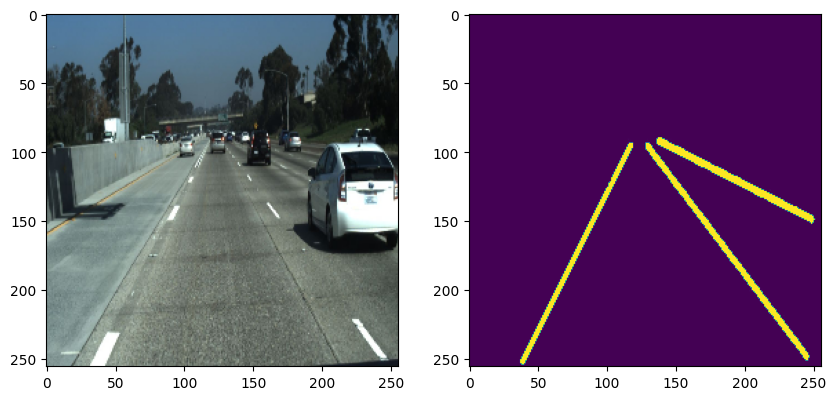

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(first_image)
plt.subplot(1, 2, 2)
plt.imshow(first_mask)

# Define model

In [16]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.layers import BatchNormalization, Dropout, ReLU
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

In [17]:
def unet(input_size=(256, 256, 3), factor: int = 1):
    inputs = Input(input_size)
    
    c1 = Conv2D(8 * factor, (3, 3), padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = ReLU()(c1)
    c1 = Conv2D(8 * factor, (3, 3), padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = ReLU()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(16 * factor, (3, 3), padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = ReLU()(c2)
    c2 = Conv2D(16 * factor, (3, 3), padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = ReLU()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(32 * factor, (3, 3), padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = ReLU()(c3)
    c3 = Conv2D(32 * factor, (3, 3), padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = ReLU()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(64 * factor, (3, 3), padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c1 = ReLU()(c1)
    c4 = Conv2D(64 * factor, (3, 3), padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = ReLU()(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # bottle neck
    c5 = Conv2D(128 * factor, (3, 3), padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = ReLU()(c5)
    c5 = Conv2D(128 * factor, (3, 3), padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = ReLU()(c5)

    # expansive path
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4], axis=3)
    c6 = Conv2D(64 * factor, (3, 3), padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = ReLU()(c6)
    c6 = Conv2D(64 * factor, (3, 3), padding='same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = ReLU()(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3], axis=3)
    c7 = Conv2D(32 * factor, (3, 3), padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = ReLU()(c7)
    c7 = Conv2D(32 * factor, (3, 3), padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = ReLU()(c7)

    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2], axis=3)
    c8 = Conv2D(16 * factor, (3, 3), padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = ReLU()(c8)
    c8 = Conv2D(16 * factor, (3, 3), padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = ReLU()(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8 * factor, (3, 3), padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = ReLU()(c9)
    c9 = Conv2D(8 * factor, (3, 3), padding='same')(c9)
    c9 = BatchNormalization()(c9)
    c9 = ReLU()(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [18]:
model = unet()

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  224         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [20]:
tf.keras.utils.plot_model(model, to_file='model/lighter_model.pdf', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [21]:
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss=BinaryCrossentropy(), 
              metrics=['accuracy']
             )

In [22]:
gc.collect()

146

In [23]:
epochs = 20

In [24]:
history = model.fit(
    train_set, 
    validation_data=test_set,
    epochs=epochs,
    shuffle=True
)

Epoch 1/20
487/487 [==============================] - 113s 200ms/step - loss: 0.4954 - accuracy: 0.8880 - val_loss: 0.4017 - val_accuracy: 0.9531
Epoch 2/20
487/487 [==============================] - 102s 210ms/step - loss: 0.3754 - accuracy: 0.9580 - val_loss: 0.3423 - val_accuracy: 0.9595
Epoch 3/20
487/487 [==============================] - 103s 211ms/step - loss: 0.3178 - accuracy: 0.9595 - val_loss: 0.2944 - val_accuracy: 0.9605
Epoch 4/20
487/487 [==============================] - 103s 211ms/step - loss: 0.2689 - accuracy: 0.9630 - val_loss: 0.2472 - val_accuracy: 0.9663
Epoch 5/20
487/487 [==============================] - 102s 209ms/step - loss: 0.2220 - accuracy: 0.9665 - val_loss: 0.1996 - val_accuracy: 0.9679
Epoch 6/20
487/487 [==============================] - 102s 208ms/step - loss: 0.1811 - accuracy: 0.9689 - val_loss: 0.1629 - val_accuracy: 0.9699
Epoch 7/20
487/487 [==============================] - 102s 209ms/step - loss: 0.1505 - accuracy: 0.9703 - val_loss: 0.1370 -

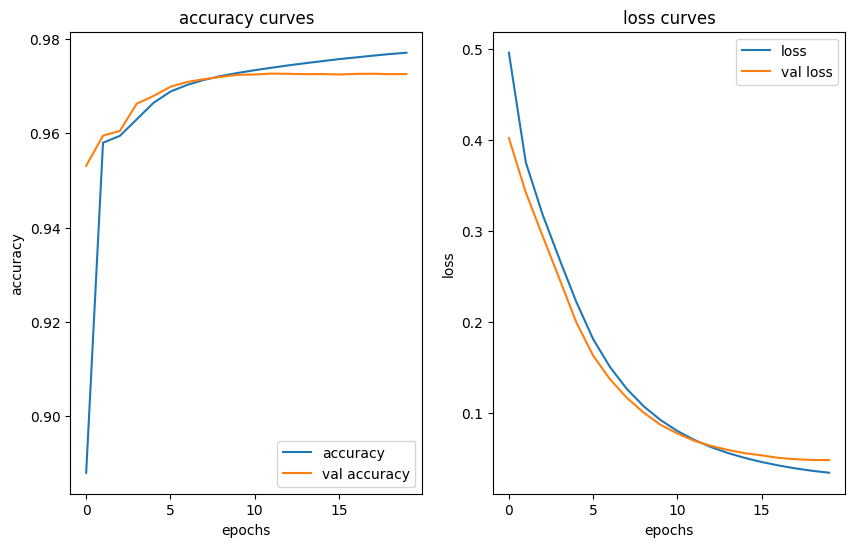

In [25]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot([i for i in range(epochs)], history.history['accuracy'], label='accuracy')
plt.plot([i for i in range(epochs)], history.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy curves')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([i for i in range(epochs)], history.history['loss'], label='loss')
plt.plot([i for i in range(epochs)], history.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss curves')
plt.legend() 

# Save the model

In [26]:
model.save("model/seg_model_another_dataset.h5")

# Load the model

In [27]:
from keras.models import load_model


loaded_model = load_model("model/seg_model_another_dataset.h5")

# Visualize the model's work

In [28]:
from random import randint


for images, masks in test_set.take(randint(3, 20)):
    test_img = images[1].numpy()
    test_mask = masks[1].numpy()

In [29]:
pred_mask = loaded_model.predict(tf.expand_dims(test_img, axis=0))
pred_mask.shape

1/1 [==============================] - 1s 882ms/step


(1, 256, 256, 1)

Text(0.5, 1.0, 'real mask')

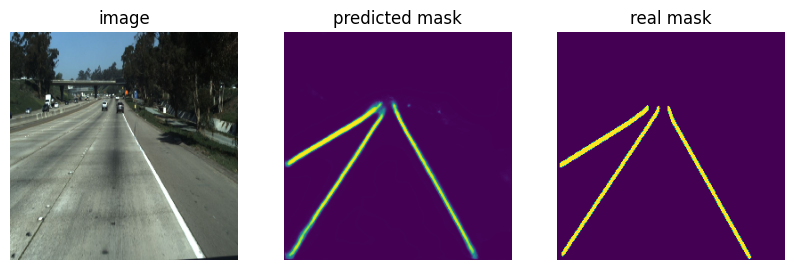

In [30]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
plt.imshow(test_img)
plt.axis('off')
plt.title('image')
plt.subplot(1, 3, 2)
plt.imshow(pred_mask[0])
plt.axis('off')
plt.title('predicted mask')
plt.subplot(1, 3, 3)
plt.imshow(test_mask)
plt.axis('off')
plt.title('real mask')

# Quantify model

In [31]:
!pip install tensorflow-model-optimization

In [32]:
# Load your trained model 
model = tf.keras.models.load_model('model/seg_model_another_dataset.h5')

def representative_dataset_gen():
    # Load your dataset or generate sample data
    for _ in range(100):  # Use a few samples for calibration
        # Generate a random input sample with the same shape as your model expects
        # Replace (1, height, width, channels) with your model's input shape
        sample_input = np.random.rand(1, 256, 256, 3).astype(np.float32)  
        yield [sample_input]

# Convert the model to a quantized version
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Set target spec for supported types (float16 or int8)
converter.target_spec.supported_types = [tf.float16]
# converter.representative_dataset = representative_dataset_gen

tflite_model = converter.convert()

# Save the quantized model
with open('model/seg_model_another_dataset.tflite', 'wb') as f:
    f.write(tflite_model)

print("Quantization complete. Model saved as 'quantized_model.tflite'.")

INFO:tensorflow:Assets written to: C:\Users\Admins\AppData\Local\Temp\tmpzbdhaez6\assets


INFO:tensorflow:Assets written to: C:\Users\Admins\AppData\Local\Temp\tmpzbdhaez6\assets


Quantization complete. Model saved as 'quantized_model.tflite'.


# Test with image not in the dataset

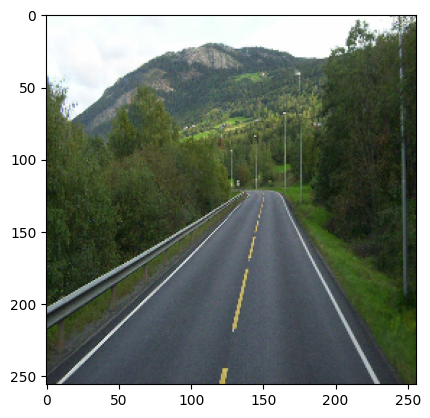

In [33]:
import cv2


real_img = plt.imread('images/test.jpg')
real_img = cv2.resize(real_img, (256, 256))
real_img = real_img/255.0
real_img = real_img.astype(np.float32)
plt.imshow(real_img)

In [34]:
pred_mask = loaded_model.predict(tf.expand_dims(real_img, axis=0))
pred_mask.shape

1/1 [==============================] - 0s 16ms/step


(1, 256, 256, 1)

Text(0.5, 1.0, 'predicted mask')

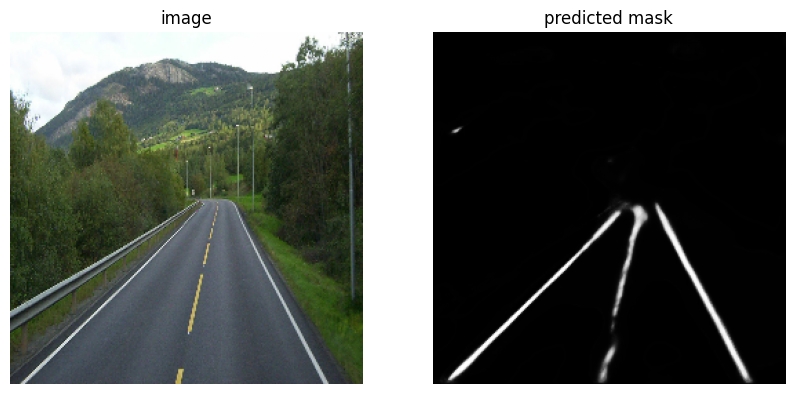

In [35]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(real_img)
plt.axis('off')
plt.title('image')
plt.subplot(1, 2, 2)
plt.imshow(pred_mask[0], cmap='gray')
plt.axis('off')
plt.title('predicted mask')

# Testing some computer vision cleaning technique

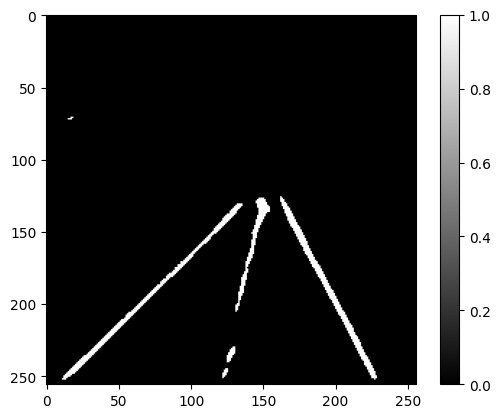

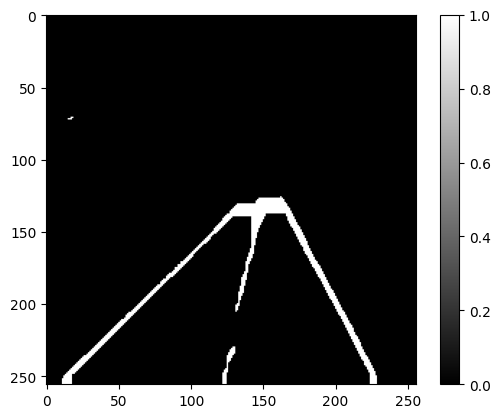

In [36]:
kernel = np.ones((5, 5))

mask = pred_mask[0].copy() > 0.5
mask = mask.astype(np.uint8) 
plt.imshow(mask[:, :, 0], cmap='gray')
plt.colorbar()
plt.show() 

# opening = cv2.morphologyEx(mask[:, :, 0], cv2.MORPH_OPEN, kernel, iterations=1)
opening = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=3)

plt.imshow(opening, cmap='gray')
plt.colorbar()
plt.show()

# Using quantized model

In [37]:
interpreter = tf.lite.Interpreter(model_path='model/quantized_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], tf.expand_dims(real_img, axis=0))

# Run the inference
interpreter.invoke()

# Get the output tensor
real_img_mask = interpreter.get_tensor(output_details[0]['index'])[0]

In [38]:
real_img.shape, real_img_mask.shape, type(real_img), type(real_img_mask), real_img.size, real_img_mask.size

((256, 256, 3), (256, 256, 1), numpy.ndarray, numpy.ndarray, 196608, 65536)

In [39]:
import pandas as pd


df = pd.DataFrame(real_img_mask[:, :, 0])
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
count,2.560000e+02,2.560000e+02,2.560000e+02,2.560000e+02,2.560000e+02,2.560000e+02,2.560000e+02,2.560000e+02,2.560000e+02,2.560000e+02,...,2.560000e+02,2.560000e+02,2.560000e+02,2.560000e+02,2.560000e+02,2.560000e+02,2.560000e+02,2.560000e+02,2.560000e+02,2.560000e+02
mean,1.305641e-03,7.874103e-05,1.787802e-05,1.419657e-05,4.755626e-05,4.483093e-05,1.044126e-04,1.106209e-04,8.931546e-05,7.392673e-05,...,4.645415e-06,4.530032e-06,4.607125e-06,4.625614e-06,5.629147e-06,7.388608e-06,1.360413e-05,3.075053e-05,9.911289e-05,6.183853e-04
std,1.157298e-02,7.599498e-04,1.284316e-04,9.212583e-05,3.810140e-04,3.749886e-04,8.851599e-04,9.471499e-04,7.694315e-04,6.336193e-04,...,7.232215e-05,6.949937e-05,6.972584e-05,6.856567e-05,8.268563e-05,1.054939e-04,1.821513e-04,3.501851e-04,1.068880e-03,4.557813e-03
min,2.076959e-09,3.751810e-16,1.061986e-19,1.880159e-21,4.368846e-22,7.158576e-23,1.462660e-22,1.007417e-22,7.600638e-23,2.914655e-23,...,4.262408e-20,4.786215e-20,1.092066e-19,2.752323e-19,7.628482e-19,3.248665e-18,7.348991e-17,2.226040e-15,1.112756e-12,1.433497e-08
25%,4.862287e-07,6.722019e-12,1.945799e-14,1.594878e-15,7.195325e-16,1.686767e-16,2.238293e-16,1.150185e-16,7.587750e-17,2.647505e-17,...,1.044408e-15,1.285630e-15,1.960791e-15,2.097524e-15,3.608641e-15,9.622932e-15,1.020912e-13,1.587348e-12,2.495969e-10,5.041635e-07
50%,1.259129e-05,3.268028e-09,8.470137e-11,2.150088e-11,1.046922e-11,3.253161e-12,3.511574e-12,2.055690e-12,9.986669e-13,4.991535e-13,...,3.566097e-11,6.767924e-11,1.175258e-10,1.479175e-10,1.912395e-10,4.613380e-10,2.473458e-09,1.864772e-08,4.589235e-07,6.668924e-05
75%,5.786669e-05,4.796985e-08,1.929519e-09,4.879629e-10,2.526692e-10,8.263321e-11,1.108234e-10,8.884838e-11,7.632773e-11,5.514792e-11,...,8.986407e-08,1.116138e-07,1.001798e-07,6.740494e-08,4.498431e-08,4.577329e-08,1.438801e-07,5.056289e-07,6.532600e-06,3.329193e-04
max,1.764185e-01,1.052055e-02,1.390364e-03,8.467622e-04,4.470752e-03,4.552629e-03,1.016784e-02,1.141154e-02,9.679916e-03,7.694311e-03,...,1.157258e-03,1.112110e-03,1.115620e-03,1.096022e-03,1.319673e-03,1.677538e-03,2.858544e-03,4.761686e-03,1.395162e-02,5.822641e-02


1.0 0.0 0.3543751


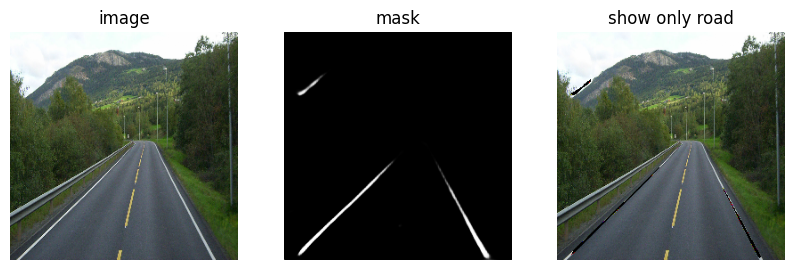

In [40]:
plt.figure(figsize=(10, 6))

axis = 'off'

plt.subplot(1, 3, 1)
plt.imshow(real_img)
plt.axis(axis)
plt.title('image')

plt.subplot(1, 3, 2)
plt.imshow(real_img_mask, cmap='gray')
plt.axis(axis)
plt.title('mask')

plt.subplot(1, 3, 3)
# real_img_mask = (real_img_mask > 0).astype(float)
result = real_img * real_img_mask[:, :, :] 
result = result > 0.5
result = np.invert(result)
result = result.astype(np.int8) * 255
result = real_img * result
result = result/255.0
plt.imshow(result)
plt.axis(axis)
plt.title('show only road')

print(result.max(), result.min(), result.mean())